In [1]:
import pandas as pd 
import numpy as np
import datetime
from pathlib import Path
import os

import xgboost as xgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns 
xgb.set_config(verbosity=2)

pd.set_option('display.max_columns', 500)


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_path = Path(os.getcwd()) / 'data' / 'WEC2022_Data'

In [3]:
data_path

WindowsPath('c:/wec_2022/wec_2022/data/WEC2022_Data')

In [4]:
def read_all_csv(data_path, data_type='train'):
    bkg_drop_cols = ['UPGRADED_FLAG', 'UPGRADE_TYPE', 'UPGRADE_SALES_DATE']
    bkg = pd.read_csv(data_path / f'BKG_{data_type}.csv', sep=';')
    if data_type == 'train': 
        bkg = bkg.drop(columns=bkg_drop_cols)
    tkt = pd.read_csv(data_path / f'TKT_{data_type}.csv', sep=';')
    fcp = pd.read_csv(data_path / f'FCP_{data_type}.csv', sep=';')
    df = fcp.merge(tkt, on='TICKET_NUMBER', how='left')
    df = df.merge(bkg, on='BOOKING_ID', how='left')
    return df 

In [5]:
df = read_all_csv(data_path=data_path)

In [6]:
# emd = pd.read_csv(data_path / 'EMD_train.csv', sep=';')

In [7]:
# df = df.merge(emd, how='left', left_on='TICKET_NUMBER', right_on='REFERENCE_TICKET_NUMBER')
# df.shape

In [8]:
# sus_air_type = (df[df['UPGRADED_FLAG'] == 'Y']['AIRCRAFT_TYPE'].value_counts() / df['AIRCRAFT_TYPE'].value_counts()).sort_values(ascending=False).head(5).index.tolist()

In [9]:
# sus_currency = (df[df['UPGRADED_FLAG'] == 1]['CURRENCY'].value_counts() / df['CURRENCY'].value_counts()).sort_values(ascending=False).head(6).index.tolist()

# Co zmieniamy 
1. 

In [10]:
def clean_df(data, data_type='train'):
    drop_cols = [
        "TICKET_NUMBER",
        "ORIGIN_AIRPORT_CODE",
        "DESTINATION_AIRPORT_CODE",
        "SALES_DATE",
        "FLIGHT_DATE_LOCAL",
        "MARKETING_CARRIER",
        "OPERATIONAL_CARRIER",
        "BOOKED_CLASS",
        "AIRCRAFT_TYPE",
        "FARE_BASIS",
        "BOOKING_ID",
        "ORIGINAL_TICKET_NUMBER",
        "SEGMENTS",
        "FLIGHT_COUPONS",
        "FORM_OF_PAYMENT",
        "CURRENCY",
        "TOTAL_PRICE",
        "LOYAL_CUSTOMER_ID",
        "LOYAL_CUSTOMER_DATE_OF_BIRTH",
        "LOYAL_CUSTOMER_REGISTERED_DATE",
        "SALES_DATE",
        "SALES_MARKET",
        "SEGMENTS",
        "INTINERARY",
        "BOOKING_ORIGIN_AIRPORT",
        "BOOKING_ORIGIN_COUNTRY_CODE",
        "BOOKING_DEPARTURE_TIME_UTC",
        "BOOKING_DESTINATION_AIRPORT",
        "BOOKING_DESTINATION_COUNTRY_CODE",
        "BOOKING_ARRIVAL_TIME_UTC",
    ]
    train_drop_cols = ["UPGRADE_TYPE",
        "UPGRADE_SALES_DATE", ]
    sus_air_type = ["763", "788", "789", "332", "787"]
    sus_currency = ["JPY", "USD", "CAD", "SGD", "VND", "AED"]
    sus_payment = [
        "UNION",
        "CCDS6",
        "CCSW9",
        "NET R",
        "CCJC3",
        "CCAX3",
        "BARTE",
        "CCVI4",
        "PAY24",
    ]
    df = data.copy()
    df["FLIGHT_DATE_LOCAL"] = pd.to_datetime(df["FLIGHT_DATE_LOCAL"])
    df["SALES_DATE"] = pd.to_datetime(df["SALES_DATE"])
    df["sale_to_flight_time"] = df["FLIGHT_DATE_LOCAL"] - df["SALES_DATE"]
    df["sale_to_flight_time"] = df["sale_to_flight_time"].apply(lambda x: x.days)

    stay_lenght_map = {-9999: np.nan}
    df["STAY_LENGTH_D"] = df["STAY_LENGTH_D"].replace(stay_lenght_map)
    df["BOOKING_ARRIVAL_TIME_UTC"] = pd.to_datetime(df["BOOKING_ARRIVAL_TIME_UTC"])
    df["BOOKING_DEPARTURE_TIME_UTC"] = pd.to_datetime(df["BOOKING_DEPARTURE_TIME_UTC"])

    df["flight_len"] = df["BOOKING_ARRIVAL_TIME_UTC"] - df["BOOKING_DEPARTURE_TIME_UTC"]
    df["flight_len"] = df["flight_len"].apply(lambda x: x.seconds / 3600)

    df["TIME_DEPARTURE_LOCAL_TIME"] = pd.to_datetime(df["TIME_DEPARTURE_LOCAL_TIME"])
    df["TIME_DEPARTURE_LOCAL_TIME"] = df["TIME_DEPARTURE_LOCAL_TIME"].apply(
        lambda x: x.hour
    )

    def get_if_add_upgrade(df, data_type):
        emd = pd.read_csv(data_path / f"EMD_{data_type}.csv", sep=";")
        return np.where(
            np.isin(df["TICKET_NUMBER"], emd["REFERENCE_TICKET_NUMBER"].unique()), 1, 0
        )

    df["if_additional_upgrade"] = get_if_add_upgrade(df, data_type=data_type)
    df["same_carrier"] = np.where(
        df["MARKETING_CARRIER"] == df["OPERATIONAL_CARRIER"], 1, 0
    )
    df["is_sus_aircraft"] = np.where(np.isin(df["AIRCRAFT_TYPE"], sus_air_type), 1, 0)

    if data_type == 'train': 
        df["UPGRADED_FLAG"] = df["UPGRADED_FLAG"].map({"Y": 1, "N": 0})

    df["is_sus_payment"] = np.where(np.isin(df["FORM_OF_PAYMENT"], sus_payment), 1, 0)
    df["intinerary_len"] = df["INTINERARY"].apply(lambda x: len(x.split("-")))
    df["is_sus_currency"] = np.where(np.isin(df["FORM_OF_PAYMENT"], sus_currency), 1, 0)

    df["PAX_GENDER"] = df["PAX_GENDER"].map({"M": 1, "F": 0})

    df["CORPORATE_CONTRACT_FLG"] = df["CORPORATE_CONTRACT_FLG"].map({"Y": 1, "N": 0})
    df["LOYAL_CUSTOMER"] = df["LOYAL_CUSTOMER"].map({"Y": 1, "N": 0})

    df["BOOKING_LONG_HOUL_FLAG"] = df["BOOKING_LONG_HOUL_FLAG"].map({"Y": 1, "N": 0})
    df["BOOKING_DOMESTIC_FLAG"] = df["BOOKING_DOMESTIC_FLAG"].map({"Y": 1, "N": 0})

    if data_type == 'train': 
        df = df.drop(columns=train_drop_cols)

    return df.drop(columns=drop_cols)

In [11]:
# sus_payment = (df[df['UPGRADED_FLAG'] == 1]['FORM_OF_PAYMENT'].value_counts() / df['FORM_OF_PAYMENT'].value_counts()).sort_values(ascending=False).head(9).index.tolist()

In [12]:
final_df = clean_df(df)

In [13]:
def oh_encoding(data): 
    df = data.copy()
    oh_cols = [
        "FLIGHT_RANGE",
        "BOOKED_CABIN",
        "VAB",
        "PAX_TYPE",
        "SALES_CHANNEL",
        "TRIP_TYPE",
    ]
    oh_df = pd.get_dummies(data[oh_cols], prefix=oh_cols, drop_first=True)
    return pd.concat([df, oh_df], axis=1).drop(columns=oh_cols)

In [14]:
final_df = oh_encoding(final_df)

In [15]:
final_df = final_df.replace({None: np.nan})

In [16]:
X = final_df.drop(["UPGRADED_FLAG"], axis="columns")
y = final_df["UPGRADED_FLAG"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from sklearn.metrics import roc_auc_score


def score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    gbm_model = xgb.train(params, dtrain, num_round,
                          verbose_eval=True)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}

def optimize(trials):

    space = {
        'n_estimators': hp.quniform('n_estimators', 10, 300, 1),
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(1, 16, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'eval_metric': 'aucpr',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'auto',
        'scale_pos_weight': 1046.6532651902328,
        'tree_method': "gpu_hist",
        'gpu_id': 0,
    }

    best = fmin(score, 
                space, 
                algo=tpe.suggest,
                trials=trials, 
                max_evals=100)
    return best


In [18]:
trials = Trials()

best_hypers = optimize(trials)

Training with params:                                  
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 1.0, 'n_estimators': 16.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9714558004409954                              


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.35000000000000003, 'eval_metric': 'aucpr', 'gamma': 0.9500000000000001, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 3.0, 'n_estimators': 260.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
  1%|          | 1/100 [00:21<35:07, 21.29s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9606957075124329                                                          


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.375, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 12, 'min_child_weight': 2.0, 'n_estimators': 137.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
  2%|▏         | 2/100 [02:13<2:02:23, 74.94s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9627333646588052                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.42500000000000004, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 91.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
  3%|▎         | 3/100 [03:15<1:51:02, 68.69s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9448330851092808                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 2.0, 'n_estimators': 71.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
  4%|▍         | 4/100 [03:55<1:32:21, 57.72s/trial, best loss: 0.028544199559004557]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9736775230246302                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.125, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 96.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.75, 'tree_method': 'gpu_hist'}
  5%|▌         | 5/100 [04:27<1:16:11, 48.12s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9707160072045327                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 1.0, 'n_estimators': 175.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
  6%|▌         | 6/100 [04:50<1:02:26, 39.86s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9681646402582126                                                            


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.45, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 7, 'min_child_weight': 6.0, 'n_estimators': 169.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
  7%|▋         | 7/100 [05:13<53:05, 34.25s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9717487572323003                                                          


Training with params:                                                              
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 2.0, 'n_estimators': 217.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8500000000000001, 'tree_method': 'gpu_hist'}
  8%|▊         | 8/100 [05:50<53:39, 35.00s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9484762567173215                                                          


Training with params:                                                                
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.42500000000000004, 'eval_metric': 'aucpr', 'gamma': 0.75, 'gpu_id': 0, 'max_depth': 11, 'min_child_weight': 3.0, 'n_estimators': 65.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
  9%|▉         | 9/100 [07:02<1:10:39, 46.59s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.945965746269051                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.4, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 10, 'min_child_weight': 1.0, 'n_estimators': 247.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 10%|█         | 10/100 [07:34<1:03:24, 42.27s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.931285256658509                                                              


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 4, 'min_child_weight': 2.0, 'n_estimators': 127.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 11%|█         | 11/100 [08:56<1:20:29, 54.26s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9702274044700637                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.05, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 3, 'min_child_weight': 5.0, 'n_estimators': 119.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 1.0, 'tree_method': 'gpu_hist'}
 12%|█▏        | 12/100 [09:20<1:06:13, 45.15s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.966143325002452                                                              


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.275, 'eval_metric': 'aucpr', 'gamma': 0.55, 'gpu_id': 0, 'max_depth': 1, 'min_child_weight': 3.0, 'n_estimators': 129.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 13%|█▎        | 13/100 [09:42<55:09, 38.04s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9637141954287155                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.47500000000000003, 'eval_metric': 'aucpr', 'gamma': 0.6000000000000001, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 1.0, 'n_estimators': 18.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9500000000000001, 'tree_method': 'gpu_hist'}
 14%|█▍        | 14/100 [09:59<45:26, 31.70s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9634609414905638                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.6000000000000001, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 2.0, 'n_estimators': 178.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 15%|█▌        | 15/100 [10:21<40:45, 28.77s/trial, best loss: 0.026322476975369824]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9746506846516444                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.375, 'eval_metric': 'aucpr', 'gamma': 0.7000000000000001, 'gpu_id': 0, 'max_depth': 8, 'min_child_weight': 1.0, 'n_estimators': 274.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.9, 'tree_method': 'gpu_hist'}
 16%|█▌        | 16/100 [11:11<49:11, 35.14s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9650529374030088                                                           


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9500000000000001, 'eta': 0.25, 'eval_metric': 'aucpr', 'gamma': 0.8, 'gpu_id': 0, 'max_depth': 2, 'min_child_weight': 4.0, 'n_estimators': 247.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.8, 'tree_method': 'gpu_hist'}
 17%|█▋        | 17/100 [12:16<1:00:57, 44.07s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9693969617643141                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.2, 'eval_metric': 'aucpr', 'gamma': 0.65, 'gpu_id': 0, 'max_depth': 15, 'min_child_weight': 5.0, 'n_estimators': 79.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.7000000000000001, 'tree_method': 'gpu_hist'}
 18%|█▊        | 18/100 [12:43<53:29, 39.15s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9646460741604217                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.8500000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 243.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.55, 'tree_method': 'gpu_hist'}
 19%|█▉        | 19/100 [13:37<58:36, 43.41s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9737966596203256                                                           


Training with params:                                                               
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.15000000000000002, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 4.0, 'n_estimators': 300.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 20%|██        | 20/100 [14:24<59:31, 44.64s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9731082093584305                                                           


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.17500000000000002, 'eval_metric': 'aucpr', 'gamma': 0.9, 'gpu_id': 0, 'max_depth': 6, 'min_child_weight': 4.0, 'n_estimators': 201.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.5, 'tree_method': 'gpu_hist'}
 21%|██        | 21/100 [15:38<1:10:29, 53.53s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9732347513715492                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.1, 'eval_metric': 'aucpr', 'gamma': 1.0, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 5.0, 'n_estimators': 208.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 22%|██▏       | 22/100 [16:16<1:03:26, 48.80s/trial, best loss: 0.025349315348355606]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(



	Score 0.9753305501256632                                                             


Training with params:                                                                 
{'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 'eta': 0.025, 'eval_metric': 'aucpr', 'gamma': 0.8500000000000001, 'gpu_id': 0, 'max_depth': 9, 'min_child_weight': 6.0, 'n_estimators': 208.0, 'objective': 'binary:logistic', 'scale_pos_weight': 1046.6532651902328, 'subsample': 0.65, 'tree_method': 'gpu_hist'}
 23%|██▎       | 23/100 [17:09<1:04:20, 50.14s/trial, best loss: 0.024669449874336835]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



In [27]:

xgb_model = xgb.XGBClassifier(
    scale_pos_weight=1046.6532651902328,
    seed=42,
    use_label_encoder=False,
    tree_method="gpu_hist",
    gpu_id=0,
)
xgb_model.fit(X_train, y_train, eval_metric="aucpr")


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1046.6532651902328,
              seed=42, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [18]:
def heatmap(model, y_test, X_test):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, model.predict(X_test))

    %matplotlib inline
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel("Predicted")
    plt.ylabel("Truth")

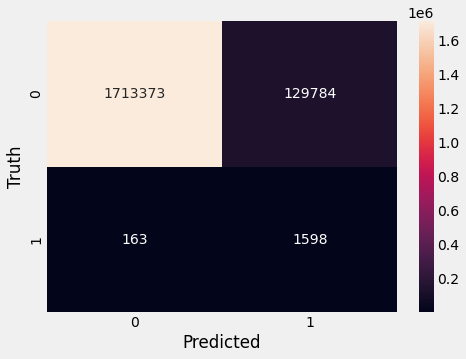

In [26]:
heatmap(xgb_model, y_test, X_test)

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.207122


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


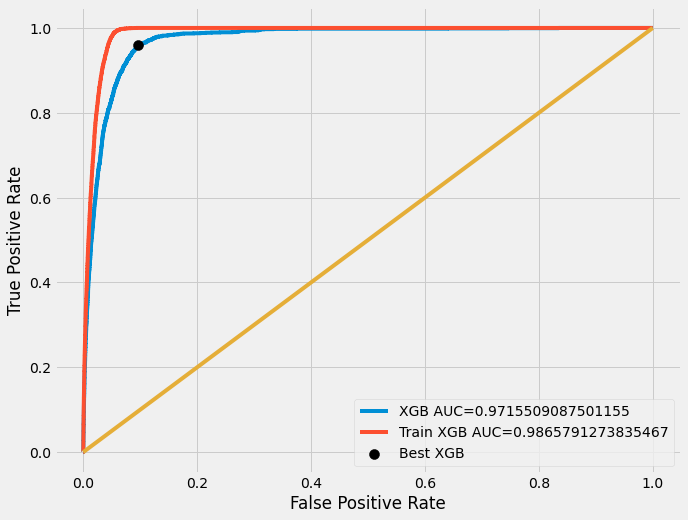

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

['SALES_CHANNEL_DCS', 'UPGRADED_FLAG']

In [31]:
test_df = read_all_csv(data_path, data_type='test')

In [38]:
clean_test = clean_df(test_df, data_type='test')

In [39]:
clean_test = oh_encoding(clean_test)

In [43]:
clean_test['SALES_CHANNEL_DCS'] = 0

In [44]:
preds = xgb_model.predict_proba(clean_test)[::,1]

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [67]:
save = pd.DataFrame({'ticket_number': test_df['TICKET_NUMBER'], 'coupon_number': test_df['COUPON_NUMBER'], 'prediction': preds})

In [79]:
save.to_csv(data_path / 'KMO_TEAM_FCP_test_results_example.csv', sep=';', index=False)

In [54]:
sample_results = pd.read_csv(data_path / 'FCP_test_results_example.csv', sep=';',)

In [80]:
# {"Message": "Your Results - Area Under ROC Curve on test dataset:0.9326799484350818", "Ranking": {"Teams": {"1": "KMO_TEAM", "2": "FREELANCE_GLANCE"}}, "status": 200}

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.207122


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


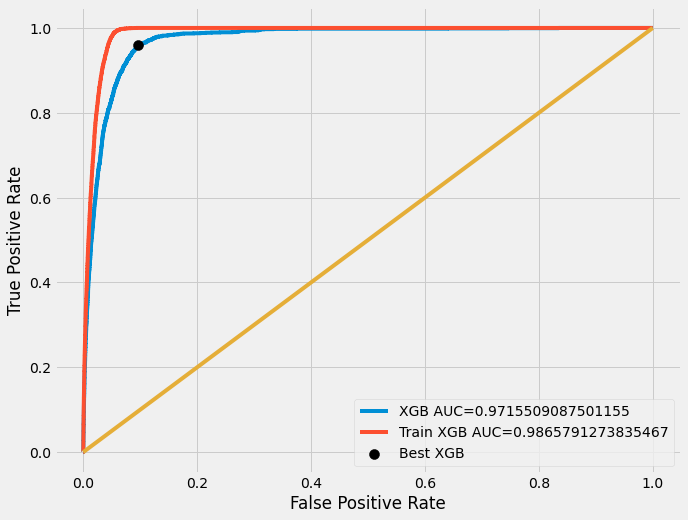

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Best Threshold=0.207122


C:\Gan\GAN-market-prediction\venv_gan\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


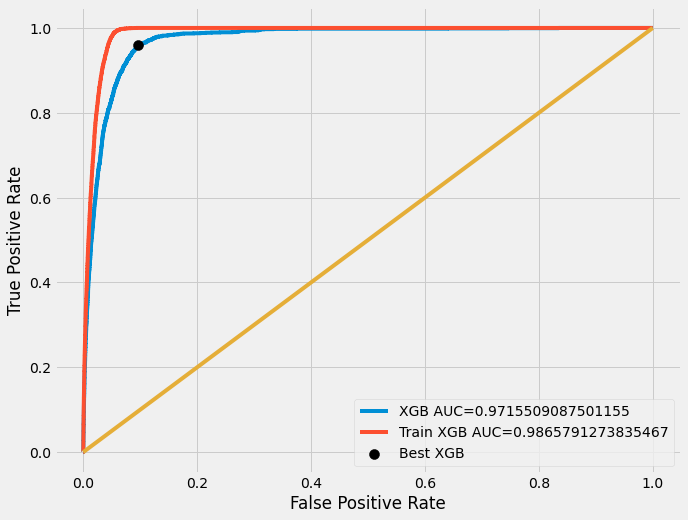

In [82]:
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import argmax
y_pred_proba = xgb_model.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

y_pred_proba2 = xgb_model.predict_proba(X_train)[::,1]
fpr2, tpr2, thresholds2 = roc_curve(y_train,  y_pred_proba2)
auc2 = roc_auc_score(y_train, y_pred_proba2)

# ROC
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label="XGB AUC="+str(auc))
plt.plot(fpr2, tpr2, label="Train XGB AUC="+str(auc2))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best XGB', s=100, zorder=3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.plot((0, 1), (0, 1))
plt.show()

Text(18.82, 0.5, 'Truth')

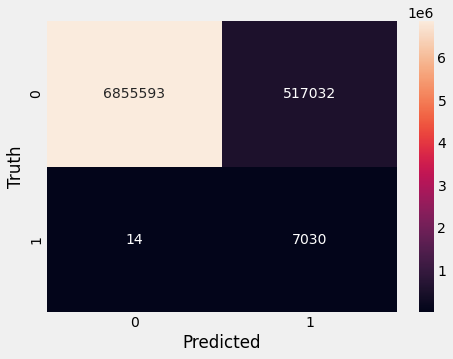

In [85]:
from sklearn.metrics import confusion_matrix
y_pred = (xgb_model.predict_proba(X_train)[:, 1] > 0.5).astype('float')
cm = confusion_matrix(y_train, y_pred)

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Truth")

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore')
xgb_model = xgb.XGBClassifier(scale_pos_weight = 1046.6532651902328, seed=42, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=5)
results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='roc_auc', fit_params={'eval_metric':'aucpr'})
print("średnia:", results.mean())
print('auc score:', results)

<BarContainer object of 40 artists>

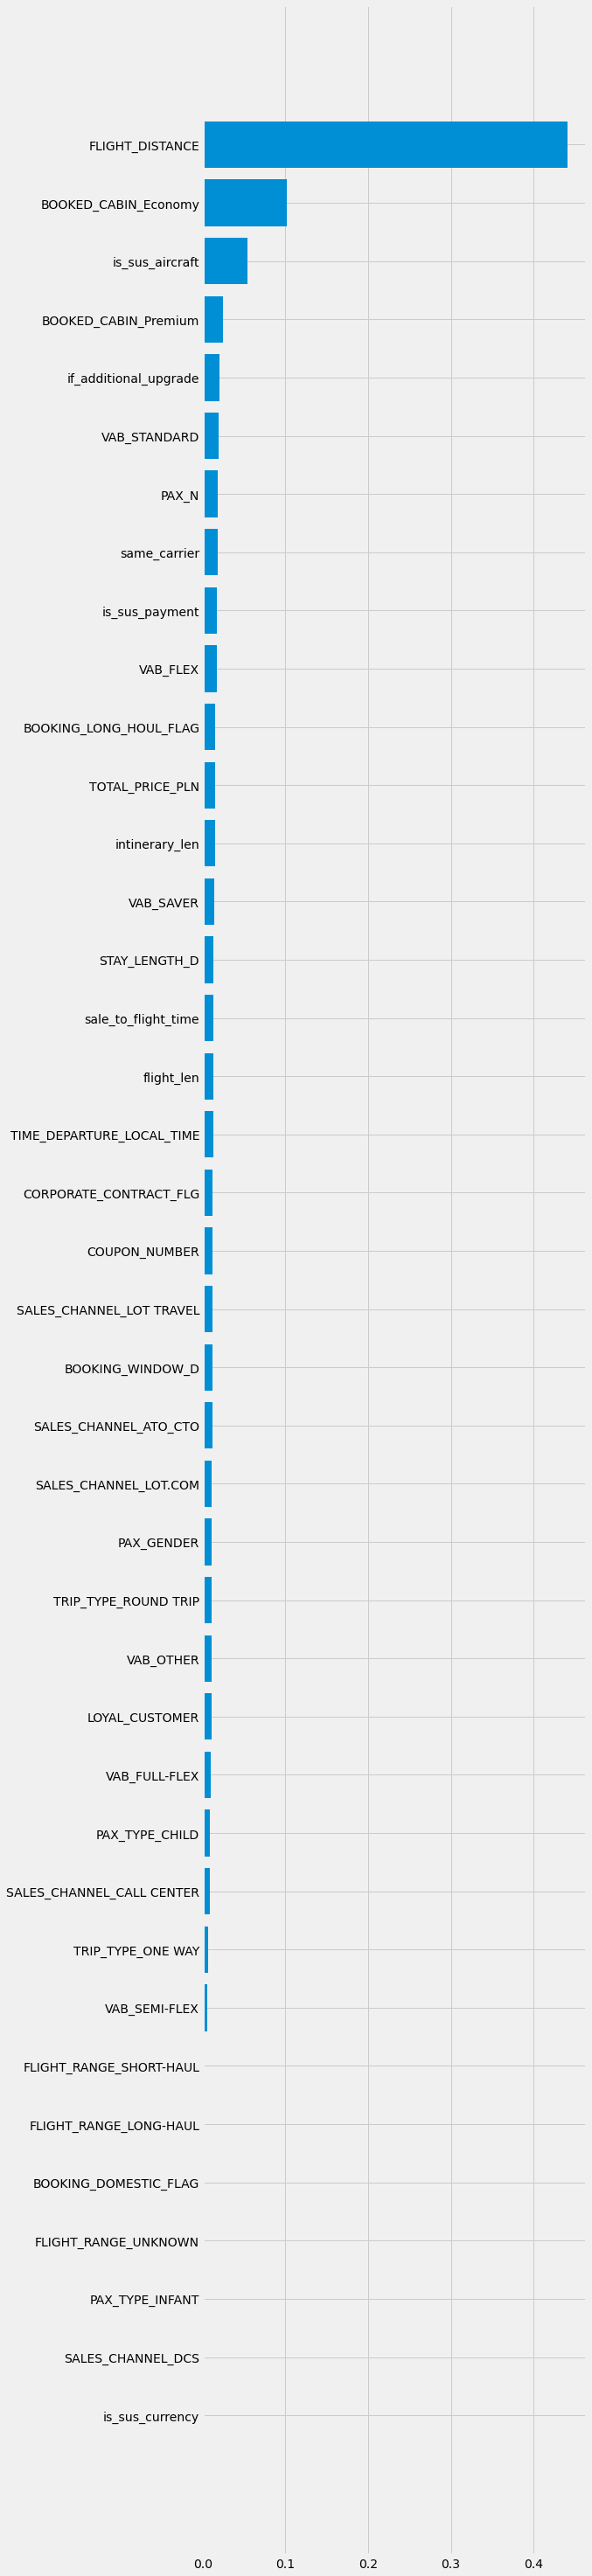

In [86]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(7,50))
plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])